## Generate a corpus

#### Initialisation

In [1]:
import os
import pandas as pd
import numpy as np
import pickle as pkl
np.set_printoptions(threshold=np.nan)

def softmax(arr):
    return np.exp(arr) / np.sum(np.exp(arr))

# Corpus parameters
K = 2
xi = 1000 # Approximate number of words
T = 25
V = 10
alphas = np.zeros((T, K))
betas = np.zeros((T, K, V))
var_init = 1
var_basic = 0.1

# Initialise the vocabulary
import string
vocab = []
for w in range(V):
    vocab.append(string.ascii_lowercase[w])

# Initialise the parameters at t=0
beta_0 = np.zeros((K, V))
for k, beta_0_k in enumerate(beta_0):
    beta_0[k] = np.random.normal(beta_0_k, var_init)
    
betas[0] = beta_0
for t in xrange (1, T):
    betas[t] = np.random.normal(betas[t-1], var_basic)
    
alphas[0] = np.random.normal(alphas[0], var_init)
for t in xrange (1, T):
    alphas[t] = np.random.normal(alphas[t-1], var_basic)

#### Corpus generation

In [2]:
corpus = {}
for d in range(T):
    corpus[d] = {}
    N = np.random.poisson(xi)
    for w in range(N):
        eta = softmax(alphas[d])
        topic_distrib = np.random.multinomial(1, eta)
        z = np.where(topic_distrib == 1)[0][0]
        beta_mp = softmax(betas[d][z])
        word_distrib = np.random.multinomial(1, beta_mp)
        w = np.where(word_distrib == 1)[0][0]
        w_key = vocab[w]
        if w_key not in corpus[d]:
            corpus[d][w_key] = 0
        corpus[d][w_key] += 1

Normalise the generated corpus

In [3]:
from preprocessing import preprocess_corpus

count_max = 200
normalise = False
corpus = preprocess_corpus(corpus, vocab, threshold=count_max, normalise=normalise)

### Run the inference

In [4]:
from dtm_alpha import DTM_alpha

iter_count = 100
var_init = 1
var_basic = 0.1
var_prop = 0.3

dtm_alpha = DTM_alpha(K=K, iter_count=iter_count, var_init=var_init, var_basic=var_basic, var_prop=var_prop)
dtm_alpha.fit(corpus)

history_alpha = dtm_alpha.history_alpha

Iteration: 10
Total alpha changes: 86
Alpha update rate: 0.3440
Iteration: 20
Total alpha changes: 127
Alpha update rate: 0.2540
Iteration: 30
Total alpha changes: 174
Alpha update rate: 0.2320
Iteration: 40
Total alpha changes: 211
Alpha update rate: 0.2110
Iteration: 50
Total alpha changes: 248
Alpha update rate: 0.1984
Iteration: 60
Total alpha changes: 279
Alpha update rate: 0.1860
Iteration: 70
Total alpha changes: 318
Alpha update rate: 0.1817
Iteration: 80
Total alpha changes: 357
Alpha update rate: 0.1785
Iteration: 90
Total alpha changes: 393
Alpha update rate: 0.1747


#### Save the corpora

In [5]:
alphas.dump('alphas_init_' + str(iter_count) + '.pkl')
history_alpha.dump('history_alpha_' + str(iter_count) + '.pkl')

#### Load corpora

In [6]:
iter_count = 200

alphas = pd.read_pickle('alphas_init_' + str(iter_count) + '.pkl')
history_alpha = pd.read_pickle('history_alpha_' + str(iter_count) + '.pkl')

### Observing the results

#### Plot the updated alphas in 3D

In [7]:
import plotly.plotly as py
from plotly.graph_objs import Surface
import plotly.graph_objs as go

n_alphas = history_alpha.shape[2]
list_alphas = []
for i in range(n_alphas):
    alpha = dict(z = history_alpha[:, :, i], type='surface')
    list_alphas.append(alpha)
fig = go.Figure(data=list_alphas)

py.iplot(fig)

#### Plot the alphas used at the corpus generation

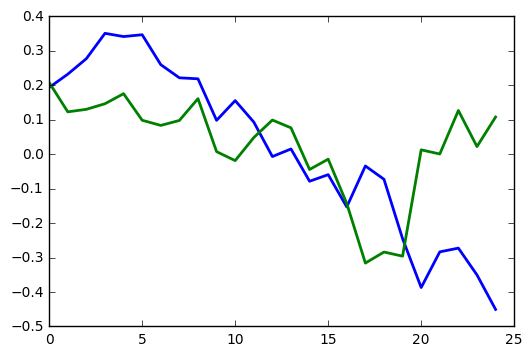

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

ts = np.linspace(0, T-1, num=T)
plt.plot(ts, alphas, linewidth=2)

#### Plot the last updated alphas

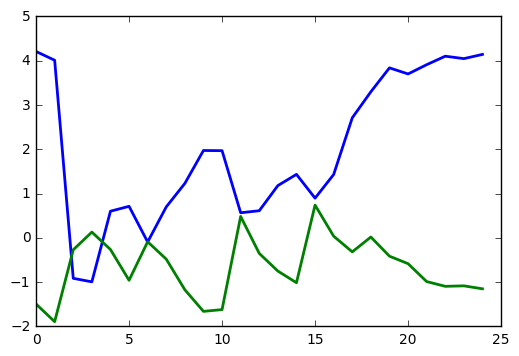

In [9]:
alphas_updated = history_alpha[iter_count-1]
plt.plot(ts, alphas_updated, linewidth=2)

#### Plot the thetas used at the corpus generation

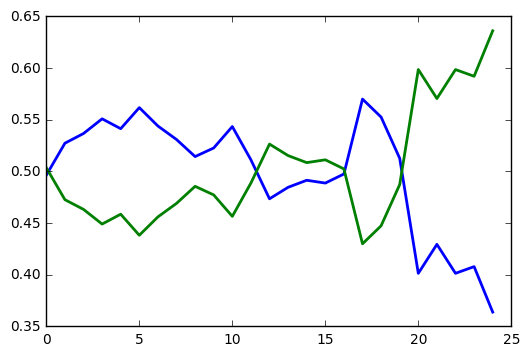

In [10]:
thetas = np.zeros(shape=alphas.shape)
for t, alpha_t in enumerate(alphas):
    thetas[t] = softmax(alpha_t)
plt.plot(ts, thetas, linewidth=2)

#### Plot the updated thetas

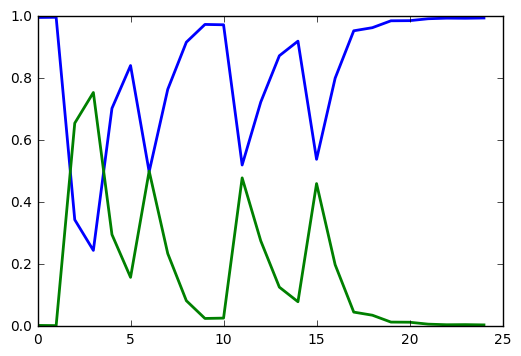

In [11]:
# alphas_updated = history_alpha[99]
thetas_updated = np.zeros(shape=alphas_updated.shape)
for t, alpha_t in enumerate(alphas_updated):
    thetas_updated[t] = softmax(alpha_t)
plt.plot(ts, thetas_updated, linewidth=2)